# Deep Q Learning

#### Can I take the findings from Q-Learning, and extend it to a deep learning framework?

#### Use this framework to incorporate Card Count?

In [1416]:
# For some reason, importing this first doesn't crash the kernel

import torch
import torch.nn as nn

torch.manual_seed(0)

In [1564]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

# Custom Modules.
from src.modules.game import Game
from src.modules.deep_q import Trainer, Net

from src.helpers.runner import select_action
from src.helpers.deep_q import update_replay_buffer, play_round, play_games
from src.helpers.plotting import plot_mesh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1336]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Observe distribution of Card Count in several games played.

The module automatically handles reshuffling, so I can just repeat play without re-initializing the module.

I have a "ratio penetrate" flag, which defaults to 2/3 . This means that the deck is reshuffled after it gets through 2/3rds of the deck. I default to 6 deck game as well. You can adjust these values in the Game module.

The distribution of count will be dependent on number of decks used, and ratio penetrate. Although with large ratio penetrate, the distribution might seem a bit misleading. This is because, if there is a large/small count at the point of reshuffling, we neglect the fact that if we play every card (instead of stopping short to reshuffle), the count will converge back to 0 by the end of the deck.

In [1337]:
rules = {
    "dealer_hit_soft17": True,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

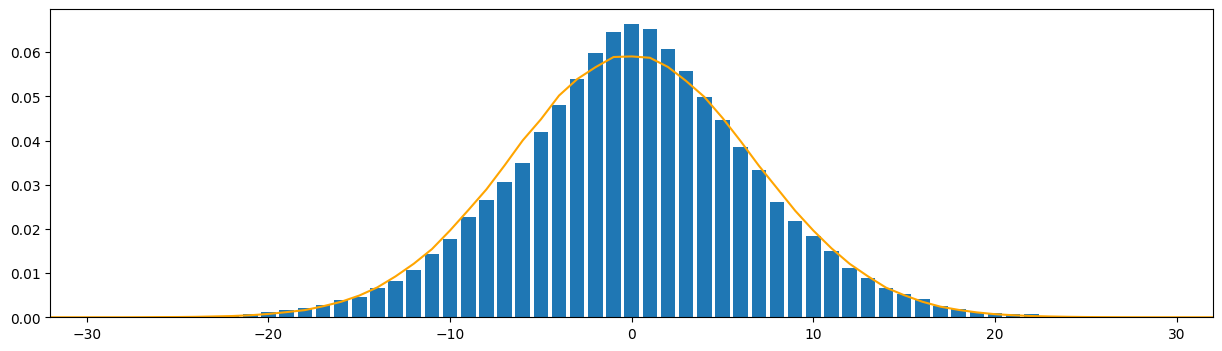

In [1338]:
blackjack = Game(**game_hyperparams)
count = []

for _ in range(50_000) :
    
    count.append(blackjack.count)
    
    blackjack.init_round(wagers=[1])
    blackjack.deal_init()
    player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
    house_show = blackjack.get_house_show(show_value=True)

    while not player.is_done() :

        player_show,useable_ace = player.get_value()

        policy = player.get_valid_moves()
        policy = [p for p in policy if p!='insurance']

        move = np.random.choice(policy)

        # Gather count after every single move.
        count.append(blackjack.count)

        blackjack.step_player(player,move)
    blackjack.step_house()
    
plt.figure(figsize=(15,4))
inds = np.argsort(pd.Series(count).value_counts(normalize=True).index.to_list())
plt.bar(
    pd.Series(count).value_counts(normalize=True).index[inds],
    pd.Series(count).value_counts(normalize=True).values[inds]
)
samples = np.random.normal(0,np.array(count).std(), 1_000_000)
minmax = max(abs(min(count)), max(count))
a, b = np.histogram(samples, np.arange(-minmax-1.5, minmax+1.5), density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])], a, color="orange")
plt.xlim(-minmax, minmax)
plt.show()

## Deep Q Learning


The Q learning without card count is found in my previous notebook. While we determine the Q function explicitly, this requires access to all state-action pairs.

In Deep Q Learning, we are approximating the Q function through use of linear + non-linear layers in a neural network, attempting to minimize MSE between Temporal Difference Q values of current and future states. We will ultimately be regressing the Q value for each possible action for a given state.

As proposed by Deepmind, we make use of a **target network** and a **q network**.

This is because, we are otherwise chasing a non-stationary target in the Q(s,a) values.

Given state $s$, we use the **q network** to compute the $Q(s,a)$ values for each action. At the same time, the **target network** uses the next state $s`$ to compute $Q(s`,a)$ for the TD target. $Q(s`,a)$ doesn't always have meaning, as taking an action in $s$ might lead us to a terminal state. In this instance, we simply look at the reward. After $M$ rounds, we copy the parameters of the **q network** over to the **target network**.
 
We can implement **experience replay**, where we store the agent's past experience in a deque and sample from this during training. So, in each epoch, simulate a round of gameplay, and store the following:
$$(state, possible_actions, action, reward, done, new_state, possible_actions_new)$$
The state, aka model inputs, are represented as:
$$(player_total, house_shows, useable_ace, can_split, first_move)$$
Typically, you'll see $(state, action, reward, done, new_state)$, without the possible actions. However, in my module (and blackjack environment in practice), not every action is possible in a given state.


### Action Masking
I want a way to implement action masking. I need this because not every action is accessible from every state. I can try this 2 different ways:
- Explicitly mask outputs based on state
- Implicitly learn this mask by heavily penalizing outcomes that select an invalid action.


#### Explicit Masking
My first attempt at handling this is by explicitly doing action masking for both **target network** and **q network**, where I have access to possible actions, and I can mask invalid ones by forcing model outputs to $-inf$. This will have the impact that in both $argmax$ and $softmax$, they will be unreachable actions and will never be used for $Q(s`,a)$ or $Q(s,a)$ action selections. Until I find a better method for this, I don't particularly like it. $Q(s,a)$ values for unreachable states are quite high even for unreachable states, and it seems to pull from the actual meaningful $Q(s,a)$ values for valid states.


#### Implicit Masking
My next approach is to implicitly penalize selections to invalid states. Given that $can_split, first_move$ are parts of the input space, the network should feasibly be able to differentiate when it can and cannot split + double. In the replay buffer, if we select an invalid action, we immediately stop gameplay simulation and add a response with a reward of $-3$ units, to heavily penalize when this happens. I can tinker with the reward value itself, as $-3$ might be too drastic during learning.

In [1565]:
BUFFER_SIZE = 10_000
GAMMA = 0.95
LR = 0.001
MIN_REPLAY_SIZE = 5_000 # this won't be hit exactly due to splitting.
TARGET_UPDATE_FREQ = 1_000
N_EPOCHS = 500_000
EVAL_EVERY = 25_000
BATCH_SIZE = 32

EPS_MIN = .1
EPS_DECAY = - np.log(EPS_MIN) / (N_EPOCHS * 0.75)

online_net = Net(5, [100,25])
target_net = Net(5, [100,25])

loss_fct = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(online_net.parameters(), lr=LR)


trainer = Trainer(
    online_net=online_net,
    target_net=target_net,
    loss=loss_fct,
    optimizer=optimizer,
    use_early_stop=False
)

In [1566]:
replay_buffer = deque(maxlen=BUFFER_SIZE)
blackjack = Game(**game_hyperparams)

for _ in range(MIN_REPLAY_SIZE):
    update_replay_buffer(
        blackjack=blackjack,
        buffer=replay_buffer,
        model=trainer.online_net,
        mode="random"
    )

In [1567]:
mean_rewards = []
training_loss = []

for step in range(N_EPOCHS):
    print(f"Round {step}", end="\r")

    eps = max(EPS_MIN, np.exp(-EPS_DECAY * step))

    mode = "argmax"
    if np.random.sample() < eps:
        mode = "random"
    # mode = "softmax"

    update_replay_buffer(
        blackjack=blackjack,
        buffer=replay_buffer,
        model=trainer.online_net,
        mode=mode
    )

    loss_epoch = trainer.train_epoch(
        replay_buffer=replay_buffer,
        batch_size=BATCH_SIZE,
        gamma=GAMMA
    )

    training_loss.append(loss_epoch)

    if not step % TARGET_UPDATE_FREQ:
        trainer.copy_online_to_target()

    if (not step % EVAL_EVERY) or (step + 1 == N_EPOCHS):
        mean_reward = await trainer.eval(
            n_games=500,
            n_rounds=50,
            wagers=[1],
            game_hyperparams=game_hyperparams
        )
        mean_rewards.append(mean_reward)
        print(f"step {step}\
 ---- mean reward per round {mean_reward:.4f}\
 ---- epoch training loss {loss_epoch:.4f}\
 ---- eps {eps:.4f}")

        if trainer.use_early_stop:
            print("Early stopping...")
            break

network = Net(5, [100,25])

network.load_state_dict(trainer.get_best_state(backtrack=False))

step 0 ---- mean reward per round -1.1504 ---- epoch training loss 1.6117 ---- eps 1.0000
step 25000 ---- mean reward per round -0.0601 ---- epoch training loss 0.5265 ---- eps 0.8577
step 50000 ---- mean reward per round -0.0619 ---- epoch training loss 0.4179 ---- eps 0.7356
step 75000 ---- mean reward per round -0.0445 ---- epoch training loss 0.5268 ---- eps 0.6310
step 100000 ---- mean reward per round -0.0149 ---- epoch training loss 0.5609 ---- eps 0.5412
step 125000 ---- mean reward per round -0.0417 ---- epoch training loss 0.2757 ---- eps 0.4642
step 150000 ---- mean reward per round -0.0535 ---- epoch training loss 0.5102 ---- eps 0.3981
step 175000 ---- mean reward per round -0.0416 ---- epoch training loss 0.3790 ---- eps 0.3415
step 200000 ---- mean reward per round -0.0569 ---- epoch training loss 0.2536 ---- eps 0.2929
step 225000 ---- mean reward per round -0.0584 ---- epoch training loss 0.3737 ---- eps 0.2512
step 250000 ---- mean reward per round -0.0586 ---- epoch 

<All keys matched successfully>

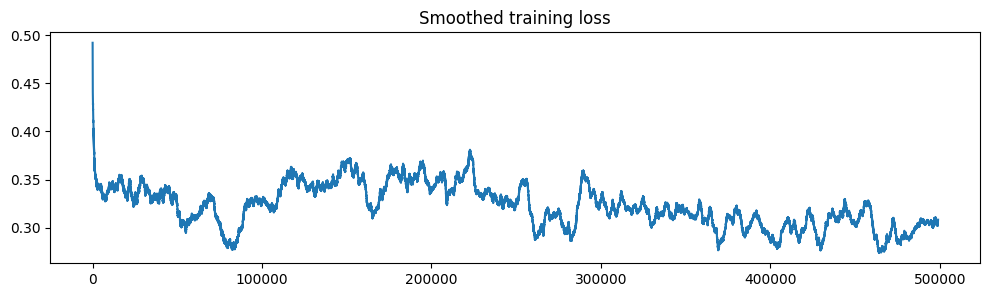

In [1568]:
plt.figure(figsize=(12,3))
plt.plot(np.convolve(training_loss, np.ones(1000)/1000, mode="valid"))
plt.title("Smoothed training loss")
plt.show()

In [1569]:
all_states = []

for player in range(4, 22):
    for house in range(2, 12):
        for ace in [0, 1]:
            if (player < 12) and ace: continue
            if (player == 21) and ace: continue
            for split in [0, 1]:
                if (player == 4) and (not split): continue
                if (player == 12) and (not split) and ace: continue
                if (player > 12) and (not player % 2) and split and ace: continue
                if (player % 2) and split: continue
                for double in [0, 1]:
                    if split and (not double): continue
                    if (player == 5) and (not double): continue
                    all_states.append((player, house, ace, split, double))

In [1570]:
value_det = np.zeros((3, 21+1, 11+1))

online_net.eval()

no_ace_no_split = list(filter(lambda x : (not x[2]) and (not x[3]) and x[-1], all_states))
yes_ace_no_split = list(filter(lambda x : (x[2]) and (not x[3]) and x[-1], all_states))
yes_split = list(filter(lambda x : x[3], all_states))

q_values = online_net.forward(torch.tensor(no_ace_no_split, dtype=torch.float32))
for i,q in enumerate(q_values):
    value_det[0, no_ace_no_split[i][0], no_ace_no_split[i][1]] = max(q)


q_values = online_net.forward(torch.tensor(yes_ace_no_split, dtype=torch.float32))
for i,q in enumerate(q_values):
    value_det[1, yes_ace_no_split[i][0], yes_ace_no_split[i][1]] = max(q)


q_values = online_net.forward(torch.tensor(yes_split, dtype=torch.float32))
for i,q in enumerate(q_values):
    player_ind = int(yes_split[i][0] / 2)
    if player_ind == 6:
        if yes_split[i][2]:
            player_ind = 11
    value_det[2, player_ind, yes_split[i][1]] = max(q)

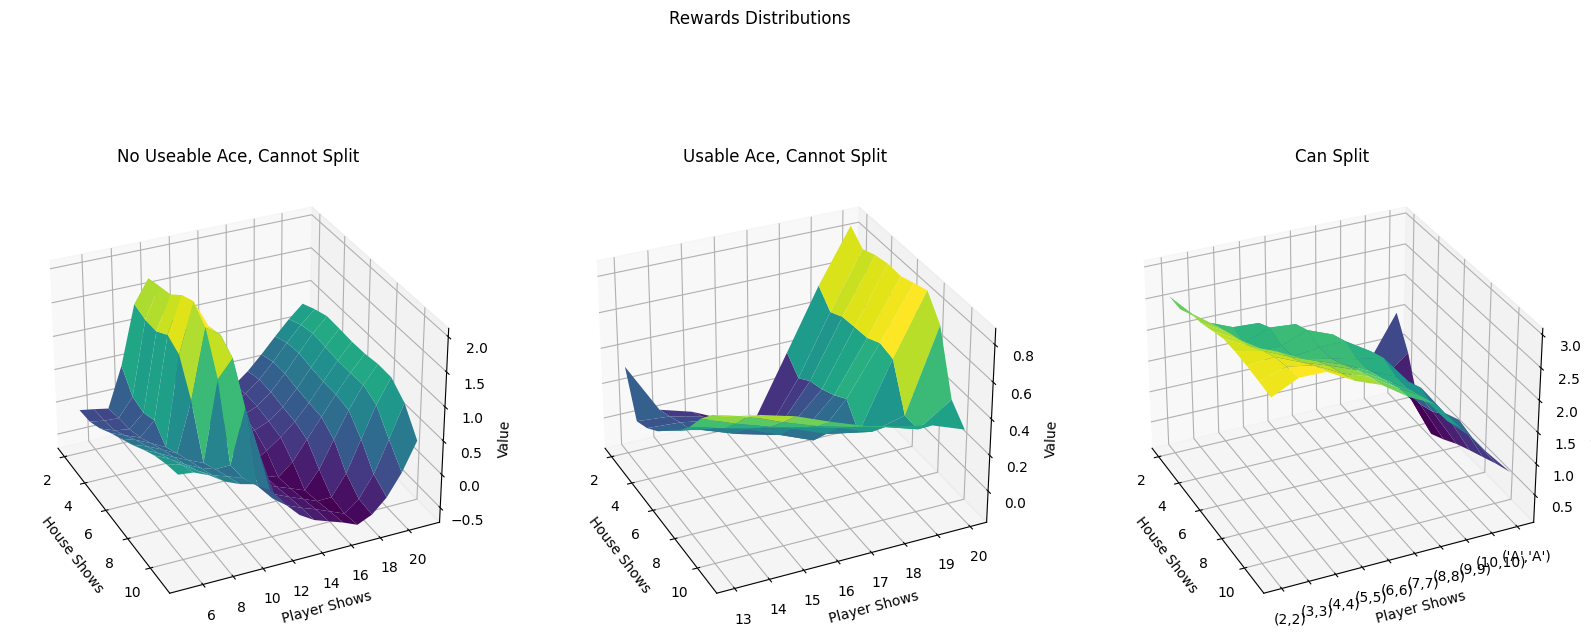

In [1571]:
fig = plt.figure(figsize=(20,8))
fig.suptitle("Rewards Distributions")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

plot_mesh(ax, value_det[0][5:,2:], [range(2,12),range(5,22)], ticks=None)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace, Cannot Split")

plot_mesh(ax, value_det[1][13:21,2:], [range(2,12),range(13,21)], ticks=None)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(ax, value_det[2][2:12,2:], [range(2,12),range(2,12)], ticks=ticks)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

In [1572]:
blackjack = Game(**game_hyperparams)


r = await play_games(
    model=trainer.online_net,
    n_games=20,
    n_rounds=100,
    wagers=[1],
    game_hyperparams=game_hyperparams
)


In [1573]:
np.mean(r[:,0,:])

-0.09475

In [1574]:
transition_inds = np.random.choice(len(replay_buffer), 32, replace=True)

obs_t = torch.tensor([replay_buffer[i][0] for i in transition_inds], dtype=torch.float32)
a_s = [replay_buffer[i][1] for i in transition_inds]
moves_t = torch.tensor([trainer.online_net.moves.index(replay_buffer[i][2]) for i in transition_inds], dtype=torch.int64).unsqueeze(-1)
rewards_t = torch.tensor([replay_buffer[i][3] for i in transition_inds], dtype=torch.float32).unsqueeze(-1)
dones_t = torch.tensor([replay_buffer[i][4] for i in transition_inds], dtype=torch.float32).unsqueeze(-1)
obs_next_t = torch.tensor([replay_buffer[i][5] or (0,0,0,0,0) for i in transition_inds], dtype=torch.float32)
a_s_next = [replay_buffer[i][6] or [] for i in transition_inds]

In [1575]:
_, target_q_argmax, _ = network.act(obs_next_t, method="argmax", avail_actions=a_s_next)

In [1576]:
target_q_argmax[:10]

tensor([[   -inf],
        [ 0.0473],
        [   -inf],
        [ 0.4056],
        [   -inf],
        [-0.0780],
        [   -inf],
        [ 0.4314],
        [   -inf],
        [   -inf]], grad_fn=<SliceBackward0>)

In [1577]:
dones_t[:10]

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]])

In [1578]:
rewards_t[:10] + torch.nan_to_num(GAMMA * (1 - dones_t[:10]) * target_q_argmax[:10], nan=0)

tensor([[ 1.0000],
        [ 0.0449],
        [ 1.0000],
        [ 0.3854],
        [ 2.0000],
        [-0.0741],
        [-1.0000],
        [ 0.4098],
        [ 1.0000],
        [-1.0000]], grad_fn=<AddBackward0>)

In [1579]:
torch.gather(input=network.forward(obs_t[:10]), dim=1, index=moves_t[:10])

tensor([[ 1.6799],
        [-0.1670],
        [ 0.8370],
        [-0.4442],
        [-2.1173],
        [-0.4501],
        [-0.2696],
        [-0.1840],
        [ 1.3779],
        [-0.4965]], grad_fn=<GatherBackward0>)

In [1580]:
obs_t[:10]

tensor([[17.,  4.,  0.,  0.,  1.],
        [ 8.,  9.,  0.,  0.,  1.],
        [12.,  5.,  0.,  0.,  1.],
        [11., 10.,  0.,  0.,  1.],
        [11.,  6.,  0.,  0.,  1.],
        [13., 10.,  0.,  0.,  1.],
        [16., 10.,  0.,  0.,  0.],
        [14., 11.,  0.,  1.,  1.],
        [19.,  9.,  0.,  0.,  1.],
        [14.,  9.,  0.,  0.,  1.]])